In [1]:
from torch.utils.data import Dataset
import torch
import albumentations as A
import cv2
import numpy as np
import pandas as pd
from albumentations import (Compose, HorizontalFlip,Resize, VerticalFlip, Rotate, RandomRotate90,
                            ShiftScaleRotate, ElasticTransform,BboxParams,
                            GridDistortion, RandomSizedBBoxSafeCrop, RandomCrop, CenterCrop,
                            RandomBrightnessContrast, HueSaturationValue, IAASharpen,
                            RandomGamma, RandomBrightness, RandomBrightnessContrast,
                            GaussianBlur,CLAHE,
                            Cutout, CoarseDropout, GaussNoise, ChannelShuffle, ToGray, OpticalDistortion,
                            Normalize, OneOf, NoOp)
from albumentations.pytorch.transforms import ToTensorV2

MEAN = np.array([0.485, 0.456, 0.406])
STD  = np.array([0.229, 0.224, 0.225])

def get_transforms_train():
    transform_train = Compose([
        Resize(1024,1024),
        #Basic
        RandomRotate90(p=1),
        HorizontalFlip(p=0.5),
        
        #Morphology
        # ShiftScaleRotate(shift_limit=0, scale_limit=(-0.2,0.2), rotate_limit=(-30,30), 
        #                  interpolation=1, border_mode=0, value=(0,0,0), p=0.5),
        # RandomSizedBBoxSafeCrop(width=1024, height=1024, erosion_rate=0.3,p=0.5),
        GaussNoise(var_limit=(0,50.0), mean=0, p=0.5),
        GaussianBlur(blur_limit=(3,7), p=0.5),
        
        #Color
        RandomBrightnessContrast(brightness_limit=0.35, contrast_limit=0.5, 
                                 brightness_by_max=True,p=0.5),
        HueSaturationValue(hue_shift_limit=30, sat_shift_limit=30, 
                           val_shift_limit=0, p=0.5),
        
        # CoarseDropout(max_holes=2, 
        #               max_height=config['input_resolution'][0]//4, max_width=config['input_resolution'][1]//4, 
        #               min_holes=1,
        #               min_height=config['input_resolution'][0]//16, min_width=config['input_resolution'][1]//16, 
        #               fill_value=0, mask_fill_value=0, p=0.5),
        
        Normalize(mean=(MEAN[0], MEAN[1], MEAN[2]), 
                  std=(STD[0], STD[1], STD[2])),
        ToTensorV2(),
    ],bbox_params=BboxParams(format="yolo",label_fields=['category_id']),)
    return transform_train


def get_transforms_valid():
    transform_valid = Compose([
        Normalize(mean=(MEAN[0], MEAN[1], MEAN[2]), 
                  std=(STD[0], STD[1], STD[2])),
        ToTensorV2(),
    ],bbox_params=BboxParams(format="yolo",label_fields=['category_id']),)
    return transform_valid


def denormalize(z, mean=MEAN.reshape(-1,1,1), std=STD.reshape(-1,1,1)):
    return std*z + mean
class Load_Bbox_Kidney(Dataset):
    def __init__(self,mode="train",csv_file = None):
        self.df = pd.read_csv(csv_file)
        self.HEIGHT = 1024
        self.WIDTH = 1024
        if mode=='train':
            self.transforms = get_transforms_train()
        else:
            self.transforms = get_transforms_valid()
    def __len__(self):
        return len(self.df)
    
    def get_image(self, name):
        """Gets the image for a given row"""
        img = cv2.imread(name)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        #image /= 255.0
        return img
    def get_mask(self,name):
        mask = cv2.imread(name.replace("images","masks").replace("_image","_mask"),0)
        return mask
    def rescale_bbox(self,boxes,width=1024,height=1024):
        bbox_list = []
        scaling_factor = 1024/256
        for bbox in boxes:
            x,y,w,h = bbox
            x = x*scaling_factor
            y = y*scaling_factor
            w = w*scaling_factor
            h = h*scaling_factor
            bbox_list.append((x,y,w,h))
        return bbox_list

    def xywh_to_xminyminxmaxymax(self,bbox):
        x_center, y_center, width, height = bbox
        x_min = (x_center - width/2) * self.WIDTH
        y_min = (y_center - height/2) * self.HEIGHT
        x_max = (x_center + width/2) * self.WIDTH
        y_max = (y_center + height/2) * self.HEIGHT
        return (x_min, y_min, x_max, y_max)
    def __getitem__(self, index):
        current_df = self.df.iloc[index]
        image = self.get_image(current_df["Image Path"])
        mask = self.get_mask(current_df["Image Path"])
        annotations = eval(current_df["bbox_coord"])
        n_boxes = len(annotations)
        
        target = {
            'boxes': torch.as_tensor(self.rescale_bbox(annotations), dtype=torch.float32),
            #'area': torch.as_tensor(area, dtype=torch.float32),
            
            # There is only one class
            'labels': torch.zeros((n_boxes,), dtype=torch.int64),
        }

        image_id = current_df["Image Name"]
        
        
        sample = {
            'bboxes': target['boxes'],
            'labels': target['labels']
        }
        # image = self.transforms(image=sample['image'])['image']
        #image = sample['image']

        #import pdb; pdb.set_trace()
        target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        
        target['boxes'] = A.core.bbox_utils.normalize_bboxes(target['boxes'],rows=self.HEIGHT,cols=self.WIDTH)
        augmented = self.transforms(image=image.astype(np.uint8), 
                                        mask=mask.astype(np.int8),
                                        bboxes= target['boxes'],
                                         category_id=[0]*n_boxes )
        image = augmented["image"]
        mask = augmented["mask"]
        target['boxes'] = [self.xywh_to_xminyminxmaxymax(box) for box in augmented["bboxes"]]
        target['boxes'] = torch.as_tensor(target['boxes'], dtype=torch.float32)
        target["labels"] = torch.ones((len(augmented["bboxes"]),), dtype=torch.int64)
        
        return image_id,image,mask,target

In [2]:
dataloader = Load_Bbox_Kidney(csv_file="/home/humanoid/internalHD/WORKS_HD/dataloaders/data_preprocess/hubmap_kidney/filtered_dataset.csv")

current id ==>  1347
================== 0


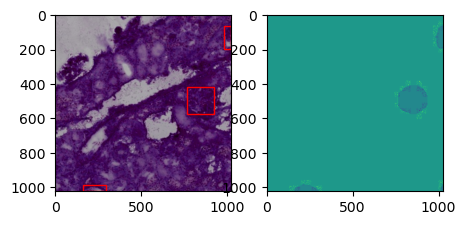

In [24]:
#check the visualization
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
def denormalize_bbox(bbox):
    x_center, y_center, width, height  = bbox
    x_min = int((x_center - width/2))
    y_min = int((y_center - height/2))
    x_max = int((x_center + width/2))
    y_max = int(y_center + height/2)
    return (x_min, y_min, x_max, y_max)
def plot_bounding_box(orig_img,orig_mask,targets,**cfgs):
    denormalize_transform =  transforms.Compose([
        transforms.Normalize(mean=[-m/s for m, s in zip(MEAN,STD)], std =[1/s for s in STD])
    ])
    row,col = cfgs["plt_size"]
    image = denormalize_transform(orig_img).permute(1,2,0).numpy()
    imgs = (image,orig_mask)
    fig , axs = plt.subplots(row,col, figsize=cfgs["fig_size"])
    for i in range(col):
        axs[i].imshow(imgs[i])
        if i ==0:
            print("==================",i)
            for bbox in targets["boxes"]:
                x_min,y_min,x_max,y_max = bbox
                rect = plt.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, fill=False, edgecolor='red')
                axs[i].add_patch(rect)
                
    plt.show()
configs = {}
configs["plt_size"] = [1,2]
configs["fig_size"] = [5,10]
idx = np.random.randint(0,len(dataloader))
print("current id ==> ", idx)
_,img,mask,targets = dataloader[idx]
plot_bounding_box(img,mask,targets, plt_size=[1,2],fig_size=[5,10])
    

In [4]:
len(targets["boxes"])

3

In [53]:
dataloader[idx]

('e79de561c_003_004_image.jpg',
 tensor([[[ 2.0263,  2.0263,  2.0263,  ...,  1.5125,  1.4098,  1.4098],
          [ 2.0263,  2.0263,  2.0263,  ...,  1.5125,  1.4098,  1.4098],
          [ 1.9920,  1.9920,  1.9920,  ...,  1.6324,  1.5297,  1.5297],
          ...,
          [ 0.5707,  0.5707,  0.8104,  ...,  1.5982,  1.5810,  1.5810],
          [ 0.5022,  0.5022,  0.7591,  ...,  1.6495,  1.6324,  1.6324],
          [ 0.5022,  0.5022,  0.7591,  ...,  1.6495,  1.6324,  1.6324]],
 
         [[ 0.5028,  0.5028,  0.4678,  ...,  0.4678,  0.3803,  0.3803],
          [ 0.5028,  0.5028,  0.4678,  ...,  0.4678,  0.3803,  0.3803],
          [ 0.5028,  0.5028,  0.5028,  ...,  0.6254,  0.5203,  0.5203],
          ...,
          [-1.1253, -1.1253, -0.8627,  ...,  0.0651,  0.0476,  0.0476],
          [-1.2304, -1.2304, -0.9678,  ...,  0.1176,  0.0826,  0.0826],
          [-1.2304, -1.2304, -0.9678,  ...,  0.1176,  0.0826,  0.0826]],
 
         [[ 2.0997,  2.0997,  2.0823,  ...,  1.5768,  1.4722,  1.472

In [32]:
data

tensor([[ 104.6261,  828.6316,  159.1652,  940.9123],
        [   0.0000,  884.7719,   25.6000, 1001.5439]])